In [2]:
import torch
#!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
torch.__version__

'2.1.0+cu121'

In [3]:
!pip3 install torch-geometric

We
will see how Vanilla Neural Networks perform on node features only by considering them as tabular
datasets. We will then experiment to include topological information in our neural networks. This
will give us our first GNN architecture: a simple model that considers both node features and edges.
Finally, we’ll compare the performance of the two architectures.

Thegraph datasets we’re going to use are richer than Zachary’s Karate Club: they have
more nodes, more edges, and include node features. In this section, we will introduce them to give
us a good understanding of these graphs and how to process them with PyTorch Geometric. Here
are the two datasets we will use:

•  The Coradataset

•  The Facebook Page-Pagedataset

 Cora(no license) is the most popular dataset for node classification
in the scientific literature. It represents a network of 2,708 publications, where each connection is a
reference. Each publicationis described as a binary vector of 1,433 unique words, where 0 and 1
indicate the absence or presence of the corresponding word, respectively. This representation is also
called a binary bag of wordsin natural language processing. Our goal is to classify each node into
one of seven categories.

In [4]:
import torch_geometric
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset_cora = Planetoid(root=".", name="Cora")

#Cora only has one graph we can store in a dedicated data variable:
data_cora = dataset_cora[0]

# Print information about the dataset
print(f'Dataset: {dataset_cora}')
print('---------------')
print(f'Number of graphs: {len(dataset_cora)}')
print(f'Number of nodes: {data_cora.x.shape[0]}')
print(f'Number of features: {dataset_cora.num_features}')
print(f'Number of classes: {dataset_cora.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data_cora.is_directed()}')
print(f'Graph has isolated nodes: {data_cora.has_isolated_nodes()}')
print(f'Graph has loops: {data_cora.has_self_loops()}')

Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


FacebookPagePage dataset was introduced by Rozemberczki et al. in 2019 . It was created using the Facebook Graph
API in November 2017. In this dataset, each of the 22,470 nodes represents an official Facebook page.
Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are
created from textual descriptions written by the owners of these pages. Our goal is to classify each node
into one of four categories:

politicians, companies, television shows, and governmental organizations.

The Facebook Page-Pagedataset is similar to the previous one: it’s a social network with a node
classification task. However, there are three major differences with Cora:

•  The number of nodes is much higher (2,708 versus 22,470)

•  The dimensionality of the node features decreased dramatically (from 1,433 to 128)

•  The goal is to classify each node into four categories instead of seven (which is easier since
there are fewer options)

In [5]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


In [6]:
import pandas as pd

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
#print(data.shape) -->AttributeError:'GlobalStorage' object has no attribute 'shape'

df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [7]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

Val_Acc=[]
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
            Val_Acc.append(val_acc)

            if(epoch % 20 == 0):
                print(f'Epoch {epoch:} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create MLP model
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Train
mlp.fit(dataset, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch 0 | Train Loss: 1.959 | Train Acc: 14.29% | Val Loss: 2.00 | Val Acc: 12.40%
Epoch 20 | Train Loss: 0.110 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 49.40%
Epoch 40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 51.00%
Epoch 60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 53.80%
Epoch 80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.37 | Val Acc: 55.40%
Epoch 100 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.34 | Val Acc: 54.60%

MLP test accuracy: 53.40%


Text(0.5, 1.0, 'MLP validation Accuracy')

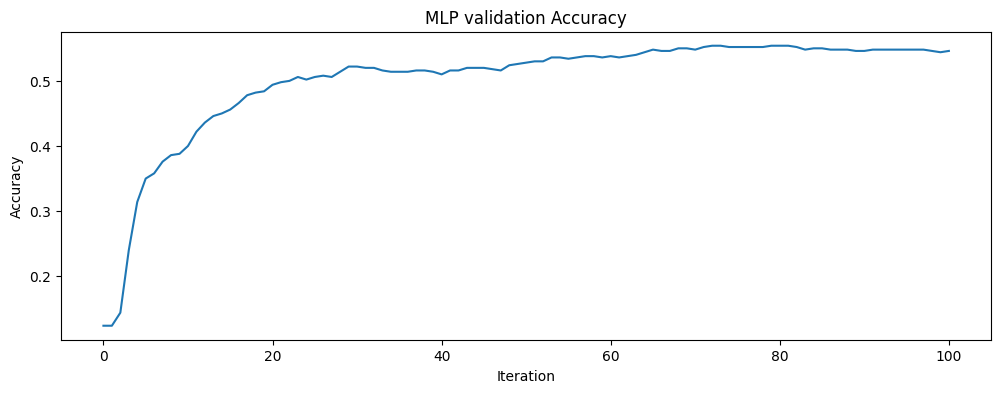

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize= (12,4))
plt.plot(Val_Acc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('MLP validation Accuracy')

In [8]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)
    #Weperform two operations – the linear transformation, and then the
    #multiplication with the adjacency matrix Ã
    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [9]:
"""Before we can create our vanilla GNN, we need to convert the edge index from
our dataset (data.edge_index) in coordinate format to a dense adjacency matrix.
We also need to include self loops; otherwise, the central nodes won’t be taken
into account in their own embeddings."""
from torch_geometric.utils import to_dense_adj
#making adjancy matrix of edges
print(type(to_dense_adj(data.edge_index)), to_dense_adj(data.edge_index).shape)

adjacency = to_dense_adj(data.edge_index)[0]
#torch.eye: Returns a 2-D tensor with ones on the diagonal and zeros elsewhere.
adjacency += torch.eye(len(adjacency))
adjacency



<class 'torch.Tensor'> torch.Size([1, 2708, 2708])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [10]:
Vali_Acc=[]
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    # We perform the same operations with our new layers, which only take the
    # adjacency matrix we previously calculated, as an additional input:
    def forward(self, x, adjacency):      #compared to: forward(self, x):
        h = self.gnn1(x, adjacency)       #compared to: self.gnn1(x)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
            Vali_Acc.append(val_acc)

            if(epoch % 20 == 0):

                print(f'Epoch {epoch:} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)   #compared to self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch 0 | Train Loss: 1.991 | Train Acc: 15.71% | Val Loss: 2.11 | Val Acc: 9.40%
Epoch 20 | Train Loss: 0.065 | Train Acc: 99.29% | Val Loss: 1.47 | Val Acc: 76.80%
Epoch 40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 2.11 | Val Acc: 75.40%
Epoch 60 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 2.22 | Val Acc: 75.40%
Epoch 80 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 2.20 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.19 | Val Acc: 77.00%

GNN test accuracy: 76.60%


Text(0.5, 1.0, 'simple GNN validation Accuracy')

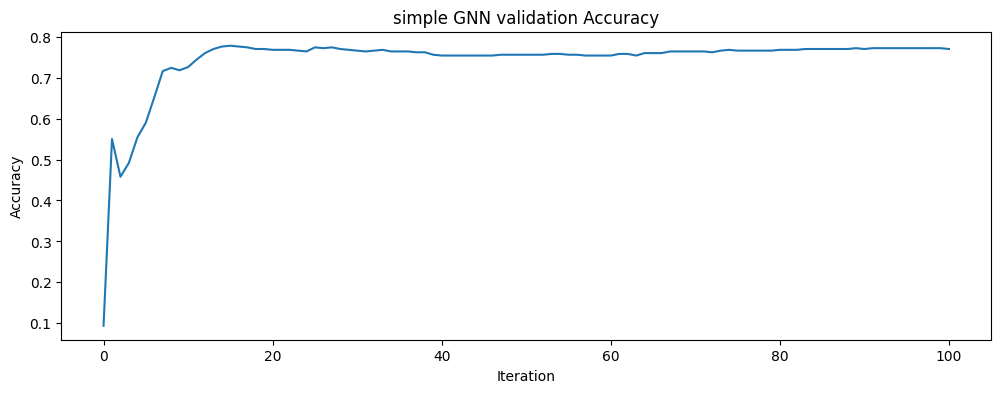

In [23]:
plt.figure(figsize= (12,4))
plt.plot(Vali_Acc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('simple GNN validation Accuracy')

Facebook dataset

# Designing the graph convolutional layer:

First, let’s talk abouta problem we did not anticipate in the previous chapter. Unlike tabular or image
data, nodes do not always have the same number of neighbors.
However, if we look at our GNN layer, we don’t take into account this difference in the number of
neighbors. Our layer consists of a simple sum without any normalization coefficient. Here is how we
calculated the embedding of a node, :

$h_i = \sum_{j \in N_i} x_j W^T$

Imagine that node 1  has 1,000 neighbors and node 2  only has 1: the embedding $ ℎ_A$  will have much
larger values than $ℎ_B$  . This is an issue because we want to compare these embeddings. How are we
supposed to make meaningful comparisons when their values are so vastly different?
Fortunately, there is a simple solution: dividing the embedding by the number of neighbors. Let’s write
deg(A) , the degree of node A. Here is the new formula for the GNN layer:

$h_i = \frac{1}{deg(i)}\sum_{j \in N_i} x_j W^T$

But how do we translate it into a matrix multiplication? As a reminder, this was what we obtained
for our vanilla GNN layer:

$H=\tilde{A}^TXW^T$ where $\tilde{A}= A+I$.

The only thing that is missing from Vanilla GNN in this formula is a matrix to give us the normalization coefficient, $\frac{1}{deg(i)}$. This is something that can be obtained thanks to the degree matrix D, which counts the number
of neighbors for each node. Here is the degree matrix for the graph G as follows:







/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


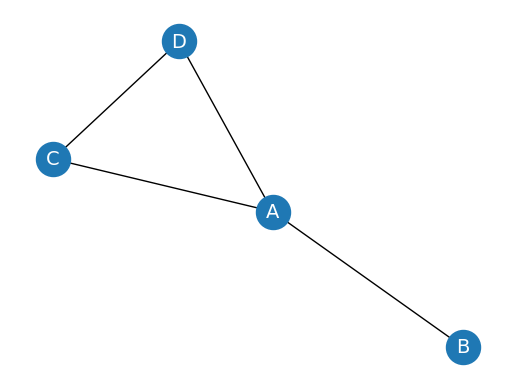

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([('A', 'B'), ('A', 'C'), ('A', 'D'), ('C', 'D')])

plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [ ]:
import numpy as np

D = np.array([
[3, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 2, 0],
[0, 0, 0, 2]
])

#D_tilde= D+I
D_tilde_inverse= np.linalg.inv(D + np.identity(4))
D_tilde_inverse

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

Now that we have our matrix of normalization coefficients, we can use $\tilde{D}^{-1} \tilde{A}^T XW^T$ that normalize every row of feature.

In [ ]:
A = np.array([
[1, 1, 1, 1],
[1, 1, 0, 0],
[1, 0, 1, 1],
[1, 0, 1, 1]
])

#D_tilde_inverse * A
print(np.linalg.inv(D + np.identity(4)) @ A)


[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]


Kipf and Welling noticed that features from nodes with a lot of neighbors spread very
easily, unlike features from more isolated nodes. In the original GCN paper, the authors proposed a
hybrid normalization to counterbalance this effect. In practice, they assign higher weights to nodes
with few neighbors using the following formula:

$H= \tilde{D}^{1/2} \tilde{A}^T \tilde{D}^{1/2} XW^T$

n terms of individual embeddings, this operation can be written as follows:

$h_i= \sum_{j \in N_j} \frac{1}{\sqrt(dig(i)\sqrt(dig(j)x_j W^T}$


# Comparing graph convolutional and graph linear layers
We saw, our vanilla GNN outperformed the Node2Vec model, but how does it
compare to a GCN? In this section, we will compare their performance on the Cora and Facebook
Page-Page datasets.
Compared to the vanilla GNN, the main feature of the GCN is that it considers node degrees to
weigh its features. Before the real implementation, let’s analyze the node degrees in both datasets. This
information is relevant since it is directly linked to the performance of the GCN.
From what we know about this architecture, we expect it to perform better when node degrees
vary greatly. If every node has the same number of neighbors, these architectures are equivalent:
(√deg(i)√deg(i)=deg(i) ):

<BarContainer object of 37 artists>

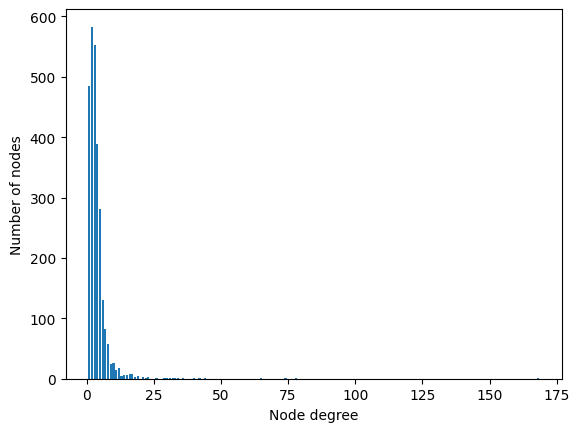

In [ ]:
# Import dataset from PyTorch Geometric
from collections import Counter
from torch_geometric.utils import degree

#Cora datest
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

<BarContainer object of 233 artists>

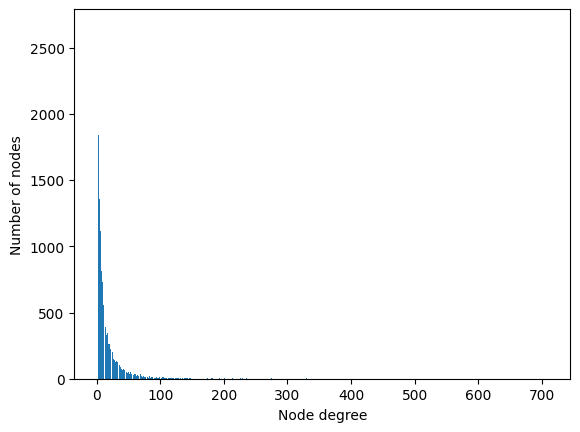

In [ ]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [11]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

Valid_Acc=[]
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
            Valid_Acc.append(val_acc)

            if(epoch % 20 == 0):
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



Text(0.5, 1.0, 'GCN validation Accuracy')

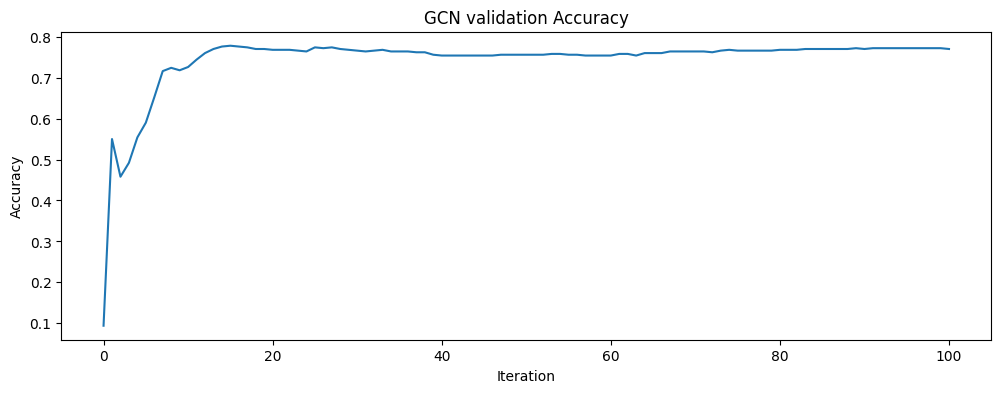

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize= (12,4))
plt.plot(Vali_Acc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('GCN validation Accuracy')

# Graph Attention Networks
Graph Attention Networks(GATs) are a theoretical improvement over GCNs. Instead of static
normalization coefficients, they propose weighting factors calculated by a processcalled self-attention.
The same process is at the core of one of the most successful deep learning architectures: the transformer,
popularized by BERTand GPT-3. Introduced by Veličković et al. in 2017, GATs have become one of
the most popular GNN architectures thanks to excellent out-of-the-box performance.

The main idea behind GATs is that some nodes are more important than others. In fact, this was
already the case with the graph convolutional layer: nodes with few neighbors were more important
than others, thanks to the normalization coefficient
1/√deg(i)√deg(j). This approach is limiting because it
only takes into account node degrees. On the other hand, the goal of the graph attention layer is to produce weighting factors that also consider the importance of node features.
Let’s call our weighting factors attention scores and note, $α_{ij}$  , the attention score between the nodes
𝑖 and j. We can define the graph attention operator as follows:
$h_i= \sum_{j \in N_i} \alpha_{ij}Wx_j$.
An important characteristic of GATs is that the attention scores are calculated implicitly by comparing
inputs to each other (hence the name self-attention). In this section, we will see how to calculate these
attention scores in four steps and also how to make an improvement to the graph attention layer:

•  Linear transformation

•  Activation function

•  Softmax normalization

•  Multi-head attention

•  Improved graph attention layer.

# Linear transformation
The attention scorerepresents the importance between a central node i and aneighbor j.
 As stated
previously, it requires node features from both nodes. In the graph attention layer, it is represented by
a concatenation between the hidden vectors $Wx_i$
and  $Wx_j$ , $[ Wx_i || Wx_j ]$ . Here, W  is a classic shared
weight matrix to compute hidden vectors. An additional linear transformation is applied to this result
with a dedicated learnable weight matrix  $W_{att}$. During training, this matrix learns weights to produce
attention coefficients  $a_ij$ . This process is summarized by the following formula:

$a_ij= W_{att}^T[ Wx_i || Wx_j ]$.

# Activation function
Nonlinearity is anessential component in neural networks to approximate nonlinear target functions.
Such functions could not be captured by simply stacking linear layers, as their final outcome would
still behave like a single linear layer.
In the official implementation (https://github.com/PetarV-/GAT/blob/master/
utils/layers.py), the authors chose the Leaky Rectified Linear Unit(ReLU) activationfunction
(see Figure 7.1). This function fixes the dying ReLUproblem, where ReLU neurons only output zero:

This isimplemented by applying the Leaky ReLU function to the output of the previous step:

$e_{ij}= LeakyReLU(a_{ij})$

However, we are now facing a new problem: the resulting values are not normalized!

# Softmax normalization
We want to compare differentattention scores, which means we need normalized values on the same
scale. In machine learning, it is common to use the softmax function for this purpose. Let’s call $N_i$
the neighboring nodes of node i, including itself:

$a_{ij}= softmax(e_{ij})=$$\frac{exp(e_{ij})}{ \sum_{k \in N_i}exp(e_{ik})}$

The result of this operation gives us our final attention scores $a_{ij}$  . But there’s another problem: self-attention is not very stable.

# Multi-head attention
This issue was already noticed by Vaswani et al. (2017) in the original transformer paper. Their proposed
solution consists of calculating multiple embeddings with their own attention scores instead of a single
one. This technique is called multi-head attention.
The implementation is straightforward, as we just have to repeat the three previous steps multiple
times. Each instance produces an embedding $ℎ_i^k$, where  k is the index of the attention head. There
are two ways of combining these results:

•  Averaging: With this, we sum the different embeddings and normalize the result by the number
of attention heads n:

$h_i= \frac{1}{n} \sum_{k=1}^n h_i^k = \frac{1}{n} \sum_{k=1}^n \sum_{j \in N_i} a_{ij}^k W^k x_j$

•  Concatenation: Here, weconcatenate the different embeddings, which will produce a larger matrix:

$h_i= ||_{k=1}^n h_i^k= ||_{k=1}^n \sum_{j \in N_i} a_{ij}^k W^k x_j$

In practice, there is a simple rule to know which one to use: wechoose the concatenation scheme when
it’s a hidden layer and the average scheme when it’s the last layer of the network. The entire process
can be summarized by the following diagram:




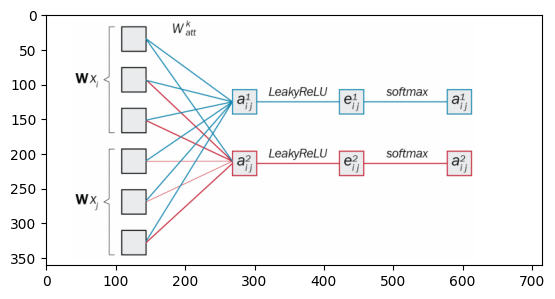

In [ ]:
import matplotlib.pyplot as plt
import cv2
img= cv2.imread('/content/drive/MyDrive/images/Untitled.png')
plt.imshow(img[...,::-1])

# Improved graph attention layer
Brody et al. (2021) argued that the graph attention layer only computes a static type of attention. This
is an issue because there are simple graph problems we cannot express with a GAT. So they introduced
an improved version, called GATv2, which computes a strictly more expressive dynamicattention.
Their solution consists of modifying the order of operations. The weight matrix W is applied after
the concatenation and the attention weight matrix $W_{att}$   after the  LeakyReLU function. In summary,
here is the original Graph Attentional Operator, also GAT:

$a_{ij}= \frac{exp(W_{att}^t LeakyReLU(W[x_i||x_j)}{\sum_{k \in N_i}  exp(W_{att}^t LeakyReLU(W[x_i||x_k)}$
And this is the modified operator, GATv2:

$a_{ij}= \frac{exp(W_{att}^t LeakyReLU(W[x_i||x_j)}{\sum_{k \in N_i}  exp(W_{att}^t LeakyReLU(W[x_i||x_k)}$
Which one should we use? According to Brody et al., GATv2 consistently outperforms the GAT and
thus should be preferred. In addition to the theoretical proof, they also ran several experiments to
show the performance of GATv2 compared to the original GAT. In the rest of this chapter, we will
consider both options: the GAT in the second section and GATv2 in the third section.

# Implementing the graph attention layer in NumPy
As previously stated, neural networks work interms of matrix multiplications. Therefore, we need
to translate our individual embeddings into operations for the entire graph. In this section, we will
implement the original graph attention layer from scratch to properly understand the inner workings
of self-attention. Naturally, this process can be repeated several times to create multi-head attention.

The first step consists of translating the original graph attention operator in terms of matrices. This
is how we defined it in the last section:

$h_i= \sum_{j \in N_i} a_{ij} Wx_j$

By taking inspiration from the graph linear layer, we can write the following:

$H= \tilde{A}^T W_a XW^T$
Where $W_α$  is a matrix that stores every $α_{ij}$.


In [ ]:
import numpy as np
np.random.seed(0)

#1. Computing adjancy matrix for our G graph example
A = np.array([
[1, 1, 1, 1],
[1, 1, 0, 0],
[1, 0, 1, 1],
[1, 0, 1, 1]
])

2. #For  X , we generate a random matrix of node features:
X = np.random.uniform(-1, 1, (4, 4))
X

array([[ 0.09762701,  0.43037873,  0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823, -0.12482558,  0.783546  ],
       [ 0.92732552, -0.23311696,  0.58345008,  0.05778984],
       [ 0.13608912,  0.85119328, -0.85792788, -0.8257414 ]])

3. The next step is to define our weightmatrices. Indeed, in graph attention layers, there are two
of them: the regular weight matrix  W , and the attention weight matrix $W_{att}$. There are different
ways to initialize them (Xavier or He initialization, for example), but we can just reuse the same
random function in this example.
The matrix  W has to be carefully designed as its dimensions are ($nb$ of hidden dimensions, $nb$ of nodes)
Notice that  nb    =4  is already fixed because it represents the number of nodes in   X . On
the contrary, the value of  nb of hidden dimension is arbitrary: we’ll choose 2  in this example:



In [ ]:
W = np.random.uniform(-1, 1, (2, 4))
W

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ],
       [ 0.95723668,  0.59831713, -0.07704128,  0.56105835]])

In [ ]:
#4. This attention matrix is applied to the concatenation of hidden vectors to
#produce a unique value. Thus, its size needs to be (1, dim h× 2) :
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[-0.95956321,  0.66523969,  0.5563135 ,  0.7400243 ]])

5. We want to concatenate hidden vectors from source and destination nodes. A simple way to
obtain pairs of source and destination nodes is to look at our adjacency matrix $\tilde{A}$
in COO
format: rows store source nodes, and columns store destination nodes. NumPy provides a
quick and efficient way of doing it with np.where():

In [ ]:
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [ ]:
#6. We can concatenate hidden vectors of source and destination nodes
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)
[connections[1]]], axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [ ]:
#7.We then apply a linear transformationto this result with the attention matrix
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X
@ W.T)[connections[1]]], axis=1).T
a

array([[-0.1007035 , -0.35942847,  0.96036209,  0.50390318, -0.43956122,
        -0.69828618,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

In [ ]:
#8.this step consists of applying a Leaky ReLU function to the previous outcome
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318, -0.08791224,
        -0.13965724,  0.79964181,  1.8607074 ,  1.40424849,  0.64260322,
         1.70366881,  1.2472099 ]])

9. We have the right values but need to place them correctly in a matrix. This matrix should look
like $\tilde{A}$
because there is no need for unnormalized attention scores when there is no connection
between two nodes. To build this matrix, we know the sources i  and destinations j  thanks to
connections. So, the first value in e corresponds to
$e_{00}$
, the second value to
$e_{01}$
, but the
seventh value corresponds to $e_{20}$
and not to $e_{12}$
. We can fill the matrix as follows

In [ ]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[-0.0201407 , -0.07188569,  0.96036209,  0.50390318],
       [-0.08791224, -0.13965724,  0.        ,  0.        ],
       [ 0.79964181,  0.        ,  1.8607074 ,  1.40424849],
       [ 0.64260322,  0.        ,  1.70366881,  1.2472099 ]])

10.The next step is to normalize every row of attention scores. This requires a custom softmax
# function to produce our final attention scores:

In [ ]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis),
        axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
W_alpha

array([[0.15862414, 0.15062488, 0.42285965, 0.26789133],
       [0.24193418, 0.22973368, 0.26416607, 0.26416607],
       [0.16208847, 0.07285714, 0.46834625, 0.29670814],
       [0.16010498, 0.08420266, 0.46261506, 0.2930773 ]])

11. This attention matrix  $W_α$  provides weights for every possible connection in the network. We
can use it to calculate our matrix of embeddings H  , which should give us two-dimensional
vectors for each node:

In [ ]:
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.10126376,  1.99749693],
       [-0.33950544,  0.97045933],
       [-1.03570438,  1.53614075],
       [-1.03570438,  1.53614075]])

Our graphattention layer is now complete! Adding multi-head attention consists of repeating
these steps with different $W$  and $W_{att}$  before aggregating the results.

# Implementing GAT:

In [ ]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset_cora = Planetoid(root=".", name="Cora")
data_cora = dataset_cora[0]

In [14]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

Validation_Acc=[]
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        """The class is initialized with two improved graph attention layers.
        Note it is important to declare the number of heads used for multi-head
        attention. The authors stated that eight heads improved performance for
        the first layer, but it didn’t make any difference for the second one"""
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            Validation_Acc.append(val_acc)

            if(epoch % 20 == 0):

                print(f'Epoch {epoch:} | Train Loss: {loss:.3f} | Train Acc: {acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create GAT
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data_cora, epochs=100)

# Test
acc = gat.test(data_cora)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch 0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.96 | Val Acc: 11.80%
Epoch 20 | Train Loss: 0.259 | Train Acc: 96.43% | Val Loss: 1.10 | Val Acc: 67.60%
Epoch 40 | Train Loss: 0.163 | Train Acc: 98.57% | Val Loss: 0.90 | Val Acc: 70.80%
Epoch 60 | Train Loss: 0.205 | Train Acc: 98.57% | Val Loss: 0.96 | Val Acc: 69.00%
Epoch 80 | Train Loss: 0.130 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 70.80%
Epoch 100 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.00%
GAT test accuracy: 82.00%


Text(0.5, 1.0, 'Validation Accuracy for GAT')

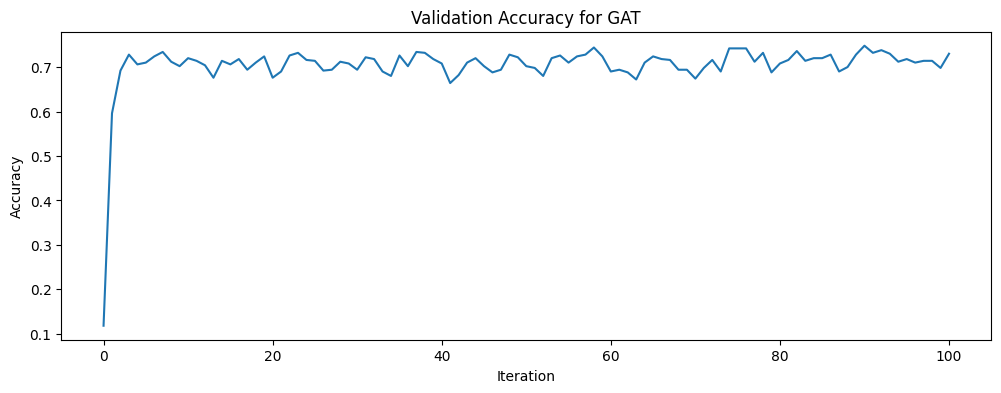

In [15]:
plt.figure(figsize= (12,4))
plt.plot(Validation_Acc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy for GAT')

In this part, we will train all 4 methods for Facebook dataset and compre time and accuracy for each method:

In [20]:
import time

Acc= []
# Dataset
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
#adjacency

# MLP
start= time.time()
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
Acc.append(acc)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')
print(f'Training for this method took {(time.time()- start)/60: .2f} min')
print('.............................................')

# GNN
start= time.time()
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
acc = gnn.test(data)
Acc.append(acc)
print(f'\nGNN test accuracy: {acc*100:.2f}%')
print(f'Training for this method took {(time.time()- start)/60: .2f} min')
print('.............................................')

# GCN
start= time.time()
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
Acc.append(acc)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')
print(f'Training for this method took {(time.time()- start)/60: .2f} min')
print('.............................................')

# GAT
start= time.time()
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)
gat.fit(data, epochs=100)
acc = gcn.test(data)
Acc.append(acc)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')
print(f'Training for this method took {(time.time()- start)/60: .2f} min')

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch 0 | Train Loss: 1.426 | Train Acc: 27.31% | Val Loss: 1.42 | Val Acc: 26.86%
Epoch 20 | Train Loss: 0.676 | Train Acc: 73.23% | Val Loss: 0.70 | Val Acc: 72.19%
Epoch 40 | Train Loss: 0.586 | Train Acc: 76.52% | Val Loss: 0.62 | Val Acc: 73.94%
Epoch 60 | Train Loss: 0.555 | Train Acc: 77.97% | Val Loss: 0.60 | Val Acc: 75.24%
Epoch 80 | Train Loss: 0.538 | Train Acc: 78.59% | Val Loss: 0.60 | Val Acc: 76.09%
Epoch 100 | Train Loss: 0.525 | Train Acc: 79.08% | Val Loss: 0.60 | Val Acc: 76.49%

MLP test accuracy: 76.31%

Training for this method took  0.07 min
.............................................
VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch 0 | Train Loss: 97.706 | Train Ac

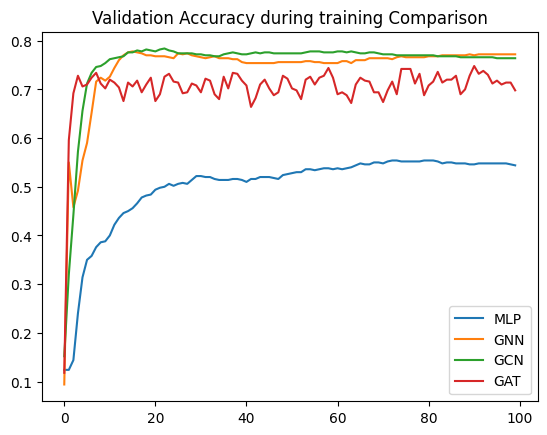

In [25]:
import matplotlib.pyplot as plt
import numpy as np

y = [ Val_Acc,  Vali_Acc, Valid_Acc, Validation_Acc]
labels = ['MLP', 'GNN', 'GCN', 'GAT']

for y_arr, label in zip(y, labels):
    plt.plot(y_arr, label=label)

plt.legend()
plt.title('Validation Accuracy during training Comparison')
plt.show()

Text(0.5, 1.0, 'Comparions')

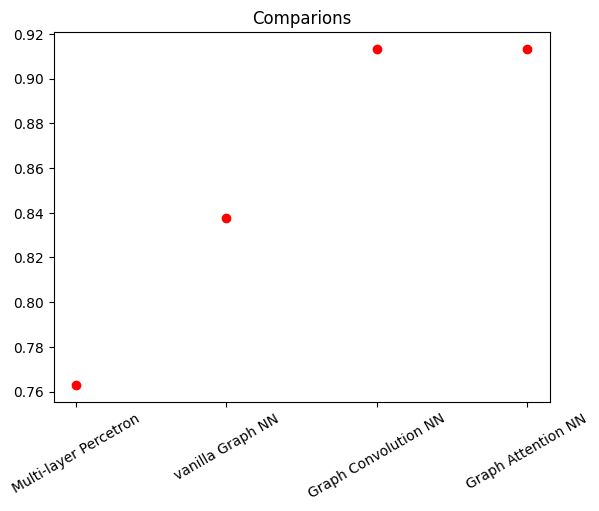

In [21]:
names= ['Multi-layer Percetron', 'vanilla Graph NN', 'Graph Convolution NN', 'Graph Attention NN']
plt.scatter(np.arange(1,5), Acc, color='red')
plt.xticks(np.arange(1,5), names, rotation=30)
plt.title('Comparions')


What if we continue training for 200 more epochs. Here is the result after 300 epochs:

In [ ]:
import numpy as np
import time

# Dataset
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

models= {'Multilayer Perceptron': mlp,
         'Vanilla GNN': gnn,
         'Graph Covolutional network': gcn,
         'Graph Attention': gat}

results= []
names= []
for name, model in models.items():
    start_time= time.time()
    model.fit(data, epochs=100)
    print(f'Method {name} training took {(time.time()- start_time)/60: .2f} min')
    test_score= model.test(data)
    results.append(test_score)
    names.append(name)
    print(name, 'accuracy after 300 epochs:', test_score)
    print('.......................................')


Epoch 0 | Train Loss: 0.477 | Train Acc: 81.22% | Val Loss: 0.61 | Val Acc: 75.84%
Epoch 20 | Train Loss: 0.476 | Train Acc: 81.18% | Val Loss: 0.62 | Val Acc: 76.34%
Epoch 40 | Train Loss: 0.469 | Train Acc: 81.54% | Val Loss: 0.62 | Val Acc: 76.14%
Epoch 60 | Train Loss: 0.464 | Train Acc: 81.70% | Val Loss: 0.63 | Val Acc: 75.79%
Epoch 80 | Train Loss: 0.461 | Train Acc: 81.86% | Val Loss: 0.63 | Val Acc: 75.74%
Epoch 100 | Train Loss: 0.457 | Train Acc: 82.00% | Val Loss: 0.64 | Val Acc: 75.99%
Method Multilayer Perceptron training took  0.10 min
Multilayer Perceptron accuracy after 300 epochs: tensor(0.7521)
.......................................
Epoch 0 | Train Loss: 0.389 | Train Acc: 89.99% | Val Loss: 0.40 | Val Acc: 89.54%
Epoch 20 | Train Loss: 0.677 | Train Acc: 85.86% | Val Loss: 0.59 | Val Acc: 85.99%
Epoch 40 | Train Loss: 0.448 | Train Acc: 87.97% | Val Loss: 0.42 | Val Acc: 88.54%
Epoch 60 | Train Loss: 0.381 | Train Acc: 89.79% | Val Loss: 0.39 | Val Acc: 89.39%
Epoc

Text(0.5, 1.0, 'Comparions')

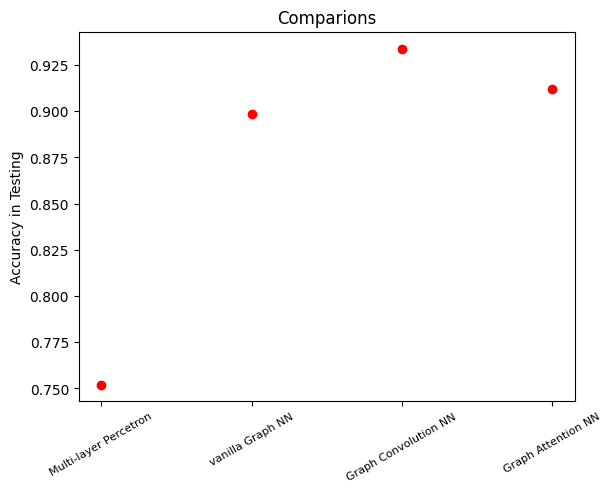

In [31]:
names= ['Multi-layer Percetron', 'vanilla Graph NN', 'Graph Convolution NN', 'Graph Attention NN']
plt.scatter(np.arange(1,5), results, color='red')
plt.xticks(np.arange(1,5), names, rotation=30, fontsize= 8)
plt.ylabel('Accuracy in Testing')
plt.title('Comparions')